## 0. 모듈임포트
-----

In [19]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp  
import urllib.request
import os
import re
import time

from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from multiprocessing import Pool
from functools import partial 

## 1. 데이터 준비 및 전처리
-----

### 데이터 불러오기

In [55]:
data = pd.read_csv('~/news_summary_more.csv', encoding='iso-8859-1')
data

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


98401개의 데이터를 갖고 있다.

In [56]:
data['headlines'][0]

'upGrad learner switches to career in ML & Al with 90% salary hike'

In [57]:
data['text'][0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

### 중복샘플 유무 확인

In [58]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


### 중복데이터 제거

In [59]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### Null 유무확인 

In [60]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


Null 데이터는 없는 것으로 확인되었다.

### 텍스트 정규화 및 불용어 처리

#### 정규화사전 정의

In [61]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


#### NLTK 불용어 리스트 가져오기

In [62]:
nltk.download('stopwords')
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 데이터 전처리 함수 정의 

In [63]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

#### 데이터 전처리 - 멀티프로세싱

In [64]:
# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, remove_stopwords),
    return texts

def preprocess_data(data, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

    text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
    pool = Pool(num_cores)

    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
    pool.close()
    pool.join()
    print('<End_time>', time.time() - start_time, "seconds")
    return processed_data

In [65]:
clean_text = preprocess_data(data['text'])  
print(clean_text)

clean_summary = preprocess_data(data['headlines'], remove_stopwords=False) 
print(clean_summary)

<End_time> 183.56758189201355 seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screen

#### 모델 길이분포

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
요약의 최소 길이 : 1
요약의 최대 길이 : 18
요약의 평균 길이 : 9.553660024400163


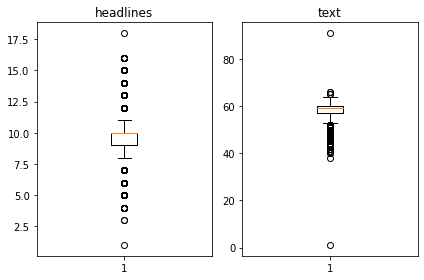

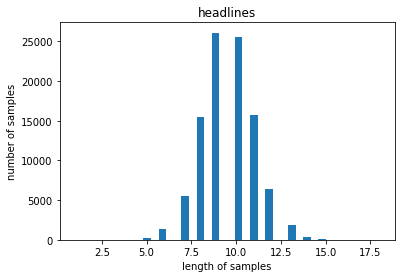

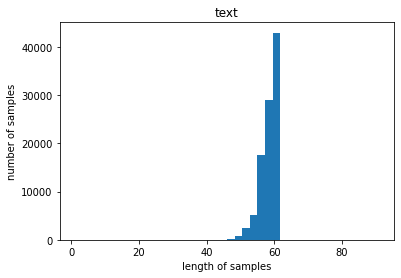

In [66]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### text와 headlines 최대 길이 설정

In [71]:
text_max_len = 60
headlines_max_len = 12

#### 전체 데이터중 최대길이 이하힌 데이터의 비율 구하는 함수 

In [72]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [73]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.997448149654331
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9768198454656364


In [74]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 95838


## 2. 모델설계 및 훈련
-----

## 3. 인퍼런스 모델 구현

## 4. 모델 테스트 및 추출적 요약
-----